# Assignment 1 - Yelp data

First, import relevent libraries. Add useful functions from the "useful gems" lab.I have also included a helper function to tell me that my browser is not crashing.

In [13]:
import tensorflow as tf
import sys
import sklearn as sk
import pandas as pd
import json
import csv
import time, sys
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from scipy.stats import zscore
import sklearn.feature_extraction.text as sk_text
from sklearn.neighbors import KNeighborsRegressor
from collections.abc import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn import metrics
import winsound

   
#Show progress bar in loop
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

    
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

#Let me know when you're done!
def beep():
    duration = 500  # milliseconds
    freq = 1040  # Hz
    winsound.Beep(freq, duration)

loadFresh=0

First determine businesses have enough reviews to be relevent for training


In [8]:
if(loadFresh):
    #Convert raw business data into tsv
    outfile = open("businesses.tsv", 'w')
    sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
    sfile.writerow(['business_id','stars', 'review_count'])
    with open('yelp_dataset/business.json', encoding="utf-8") as f:
     i=0
     for line in f:
        row = json.loads(line)
        if(row['review_count']>=20):
            sfile.writerow([row['business_id'], row['stars'], (row['review_count'])])
        i=i+1
        update_progress(i / 192610)

    update_progress(1);
    outfile.close()

Progress: [####################] 99.9%


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [11]:
#load business table
business_df= pd.read_csv('businesses.tsv', delimiter ="\t", encoding="utf-8")
business_df=business_df.sort_values('business_id');
business_df

,business_id,stars,review_count
45042,--1UhMGODdWsrMastO9DZw,4.0,24
11344,--6MefnULPED_I942VcFNA,3.0,44
29166,--7zmmkVg-IMGaXbuVd0SQ,4.0,58
49157,--9e1ONYQuAa-CB_Rrw7Tw,4.0,1613
37751,--DaPTJW3-tB1vP-PfdTEg,3.5,49
...,...,...,...
44660,zzsOLFhgUw8gnjLTVVItFA,4.5,105
13453,zzwaS0xn1MVEPEf0hNLjew,3.5,68
356,zzwhN7x37nyjP0ZM8oiHmw,4.0,54
46061,zzwicjPC9g246MK2M1ZFBA,3.0,70


Found 57644 with enough reviews to be useful. All stored in business_df, ordered by business ID

## Review data
Open the review data and convert into a TSV with only the relevent information. Runs a progress bar while loading. To save space, only writes to file if the business has 20 reviews or more.

In [ ]:
if(loadFresh):
    #Convert raw review data into TSV
    outfile = open("review_stars.tsv", 'w')
    sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
    sfile.writerow(['business_id','stars', 'text'])
    with open('yelp_dataset/review.json', encoding="utf-8") as f:
     i=0
     for line in f:
        row = json.loads(line)
        # Check if businessID if present in business table
        if(row['business_id'] in business_df['business_id'].tolist()):
            # some special char must be encoded in 'utf-8'
            sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])
        update_progress(i / 2000000)
        i=i+1

    update_progress(1);
    outfile.close()

In [12]:
#load review data
df= pd.read_csv('review_stars-small.tsv', delimiter ="\t", encoding="utf-8")
df

,business_id,stars,text
0,ujmEBvifdJM6h6RLv4wQIg,1.0,b'Total bill for this horrible service? Over $...
1,NZnhc2sEQy3RmzKTZnqtwQ,5.0,"b""I *adore* Travis at the Hard Rock's new Kell..."
2,WTqjgwHlXbSFevF32_DJVw,5.0,"b""I have to say that this office really has it..."
3,b1b1eb3uo-w561D0ZfCEiQ,1.0,b'Today was my second out of three sessions I ...
4,eU_713ec6fTGNO4BegRaww,4.0,b'I\'ll be the first to admit that I was not e...
...,...,...,...
42205,nrahyQyopCtajDqUtVVVfA,2.0,b'My husband and I thought we would give The S...
42206,RJdSwvgAd2TRdQw4iOsrag,4.0,"b""Petit caf\xc3\xa9 sympa, peu de place assise..."
42207,coGEHGuUtnABP7KHgGlmRg,5.0,b'Absolutely delicious! The food was full of a...
42208,cMAv53bpH7b32IYgQwCXLA,2.0,b'i would understand a 2 hour wait for food if...


## Language preprocessing
First, aggregates all reviews under their business ID. Then we can run TFIDF on the sum of all the reviews in preparation to do language analysis.

In [14]:
#groups reviews by businessID
df_review_group=df.groupby('business_id')['text'].sum()
df_reviews = pd.DataFrame({'business_id':df_review_group.index, 'all_reviews':df_review_group.values})
df_reviews

#language preprocessing
vectorizer = sk_text.TfidfVectorizer(stop_words='english',
                             min_df=2, 
                             max_df=500,
                                    max_features=1000)

#df_reviews['all_reviews'] = vectorizer.fit_transform(df_reviews['all_reviews'])
vector_reviews=vectorizer.fit_transform(df_reviews["all_reviews"])

#split off business ID
col_id=df_reviews['business_id']
#create dataframe from vectored reviews
df_vector_reviews=pd.DataFrame(vector_reviews.todense())
#concat to single dataframe
df_tfidf_reviews=pd.concat([col_id,df_vector_reviews],axis=1)

display(df_tfidf_reviews)

,business_id,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,--I7YYLada0tSLkORTHb5Q,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,-092wE7j5HZOogMLAh40zA,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,-1VaIJza42Hjev6ukacCNg,0.148201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.061096,0.0,0.0,0.058525,0.0,0.0,0.0,0.054603,0.0
3,-1xuC540Nycht_iWFeJ-dw,0.041202,0.0,0.0,0.051884,0.0,0.0,0.0,0.0,0.0,...,0.267194,0.254787,0.0,0.0,0.048813,0.0,0.0,0.0,0.030361,0.0
4,-49WY_TEa9ZEcRk_GnuLog,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,zyPGYeXF4XKCqNN1pjFWhg,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
5134,zyr5pzOs3SJIX3K-nvC2zg,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
5135,zz3CqZhNx2rQ_Yp6zHze-A,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
5136,zzOo9n22fBbKAhbSpMzggA,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [16]:
#join total reviews with aggregated review data
df_join=pd.concat([df, df_tfidf_reviews], axis=1, join='inner')
#drop unnecesary info
df_sklearn_ready=df_join.drop(columns=['business_id', 'text'])
df_sklearn_ready

,stars,0,1,2,3,4,5,6,7,8,...,990,991,992,993,994,995,996,997,998,999
0,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,5.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,5.0,0.148201,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.061096,0.0,0.0,0.058525,0.0,0.0,0.0,0.054603,0.0
3,1.0,0.041202,0.0,0.0,0.051884,0.0,0.0,0.0,0.0,0.0,...,0.267194,0.254787,0.0,0.0,0.048813,0.0,0.0,0.0,0.030361,0.0
4,4.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5133,3.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
5134,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
5135,5.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
5136,5.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


Y is our list of reviews and X is your table of language data.

In [17]:
#get arrays for training
x,y = to_xy(df_sklearn_ready,"stars")


In [18]:
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

Now the data is clean and it's time to feed it to the AI

# Machine learning

We fit the model to the data and view the results.

Train on 3596 samples, validate on 1542 samples
Epoch 1/1000
3596/3596 - 1s - loss: 19.8092 - val_loss: 15.3038
Epoch 2/1000
3596/3596 - 0s - loss: 12.5661 - val_loss: 10.2253
Epoch 3/1000
3596/3596 - 0s - loss: 7.7404 - val_loss: 6.0416
Epoch 4/1000
3596/3596 - 0s - loss: 4.2085 - val_loss: 3.9073
Epoch 5/1000
3596/3596 - 0s - loss: 2.6956 - val_loss: 3.4045
Epoch 6/1000
3596/3596 - 0s - loss: 2.1127 - val_loss: 3.2333
Epoch 7/1000
3596/3596 - 0s - loss: 1.7513 - val_loss: 3.1736
Epoch 8/1000
3596/3596 - 0s - loss: 1.4966 - val_loss: 3.1326
Epoch 9/1000
3596/3596 - 0s - loss: 1.3120 - val_loss: 3.1609
Epoch 10/1000
3596/3596 - 0s - loss: 1.1573 - val_loss: 3.1586
Epoch 11/1000
3596/3596 - 0s - loss: 1.0286 - val_loss: 3.1867
Epoch 12/1000
3596/3596 - 0s - loss: 0.9237 - val_loss: 3.2067
Epoch 13/1000
3596/3596 - 0s - loss: 0.8307 - val_loss: 3.2198
Epoch 00013: early stopping
Train on 3596 samples, validate on 1542 samples
Epoch 1/1000
3596/3596 - 1s - loss: 11.1162 - val_loss: 7.2730

Epoch 10/1000
3596/3596 - 0s - loss: 0.7549 - val_loss: 3.2744
Epoch 11/1000
3596/3596 - 0s - loss: 0.6491 - val_loss: 3.2839
Epoch 12/1000
3596/3596 - 0s - loss: 0.5546 - val_loss: 3.2972
Epoch 00012: early stopping
RSME Score:  1.7699249


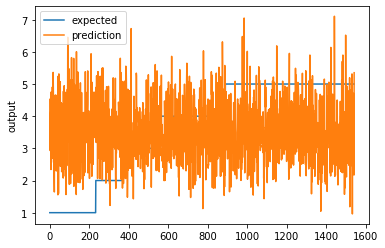

In [22]:
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(10):
    model = Sequential()

    #in experiments sigmoid turned out to have somewhat better results than relu
    model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1     #  why input_dim=x.shape[1]?  
    model.add(Dense(10, activation='relu')) # Hidden 2
    model.add(Dense(1)) # Output

    #use adam works better than sdg on this particular model
    #adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
model.load_weights('best_weights.hdf5') # load weights from best model

#view model
pred=model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("RSME Score: ",score)
chart_regression(pred.flatten(),y_test)

RSME Score:  1.7699249


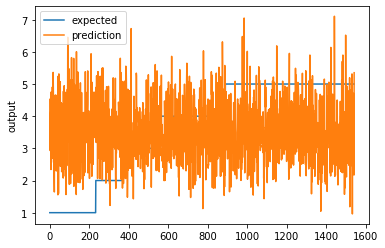

In [24]:

#view model
pred=model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("RSME Score: ",score)
chart_regression(pred.flatten(),y_test)

## Save the best one

In [ ]:
import os
# save entire network to HDF5
model.save("network.hdf5")

In [ ]:
from tensorflow.keras.models import load_model

model2 = load_model("network.hdf5")
pred = model2.predict(x_test)
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("After load score (RMSE): {}".format(score))
chart_regression(pred.flatten(),y_test)

In [25]:
beep()